# Dimensionless SE
We work in units

$$ x=r_0 \hat{r}; \quad t = 2mr_0^2 \hat{t}; \quad \psi = \psi_0 \hat{\psi}$$
such that the nonlinear Schrodinger Equation takes the form:
$$ i \hat{\psi}' = -\hat{\nabla}^2 \hat{\psi} + \epsilon |\hat{\psi}|^2\hat{\psi}$$
where $(...)'$ denotes dimensionless time derivative and
$$\epsilon = g m r_0^2\psi_0^2$$. We will take $r_0$ to be some input de Broglie wavelength, and $\psi_0 = \sqrt{\rho_{0}/m}$.

## Weakly nonlinear regime
We have turned off gravity. This is reasonable if ...

Further conditions:

Try to impose that the simulation time $T$ satisfies:

$$T \ll t_{\text{cross}}$$
where $t_{\text{cross}}$ is the crossing time for the fast mode $k_{max}$:
$$
t_{\text{cross}} = \frac{mL}{k_{max}}.
$$
This means most modes will not cross the boundary.

From testing, it seems that there is a quick 'relaxation' period where $\delta_{rms}$ drops off. I think this corresponds to the Nyquist time:
$$
t_{Nyq} = \frac{2\pi}{\omega_{Nyq}} = \frac{4 \pi m}{k_{max}^2}.
$$

Probably also want to run it for multiple de Broglie oscillations:
$$
t_{dB} = \frac{m}{k_0^2}
$$



# Loop over couplings

In [50]:
from RandomPhaseGenerator import RandomPhase3d
from PowerSpectrum import PowerSpectrum3d
from SchroPoissonSolver import fdmSimulation3d
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc, rcParams
# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to ‘Computer Modern’
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=5)
rc('xtick', labelsize=14)
rc('ytick.major', size=5, pad=5)
rc('ytick', labelsize=14)



def pipeline(rho_init, length, resolution, pow_dt, t_end, avg_density, couplings):
    norm = avg_density
    N = resolution
    N_half = int(N/2)
    N_g = couplings.size

    t_cross = L/k_max/2
    dt = (1/N)**pow_dt
    N_steps = int(t_end/dt)

    print("number steps:"+str(N_steps))

    Nt_saved = int(N_steps/2)
    
    PS_array = np.zeros((N_g, N_half))
    deltas_array = []#np.zeros((N_g, Nt_saved))
    psis_array = np.zeros((N_g, Nt_saved, N, N, N), dtype=complex)
    
    i = 0
    for g in couplings:
        deltas, psis, t_vals = fdmSimulation3d(rho_init, norm, length, 0, g, t_end, dt, Nt_saved)

        spectra = []

        for j in range(Nt_saved):
            k_modes, PS = PowerSpectrum3d(np.abs(psis[j,:,:,:])**2, length)
            spectra.append(PS)
            
        PSavg = np.average(spectra, axis=0)  
        PS_array[i,:] = PSavg
#         deltas_array[i,:] = deltas
        deltas_array.append(deltas)
        psis_array[i,:,:,:,:] = psis

        i += 1
    return t_vals, np.asarray(deltas_array), k_modes, PS_array, psis_array


N = 128
dB = 1
L = 18*dB
k_dB = 2*np.pi / dB
k_min = 2*np.pi/L
k_max = 2*np.pi*N/L

t_dB = np.pi/k_dB**2
t_cross = L/k_max/2

psi0, rho0 = RandomPhase3d(N, dB, L)
k_modes, PS0 = PowerSpectrum3d(rho0, L)

norm = 1e0
power = 1.25 # dt = dx**power

epsilons = np.array([0,-1e-2,-5e-3, -2e-3,-1e-3,1e-3,2e-3,5e-3,1e-2]) #put e=0 first
# epsilons = np.array([0,-1e-3,1e-3])

t_vals, deltas, k_modes, spectra, psis = pipeline(rho0, L/dB, N, power, t_cross, norm, epsilons)

number steps:86


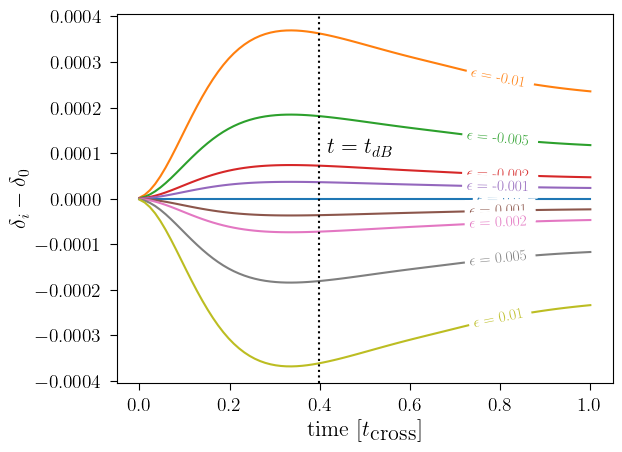

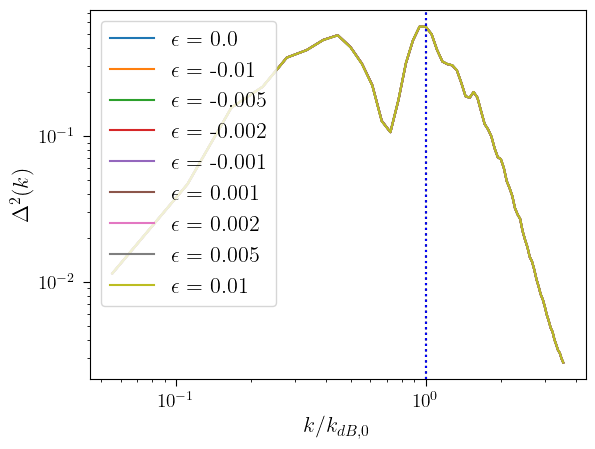

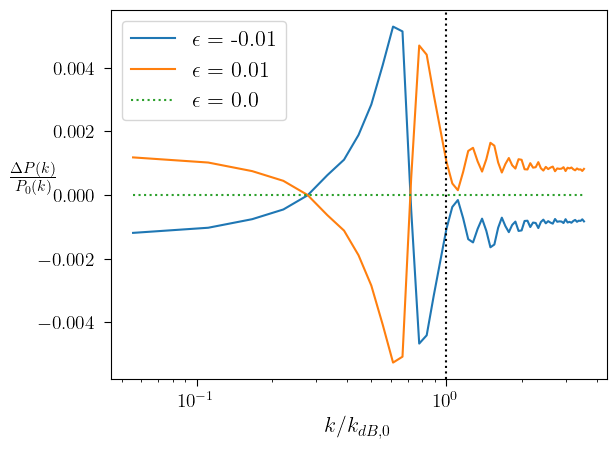

In [51]:
# !pip install matplotlib-label-lines
from labellines import labelLines

plt.figure()
i=0
for g in epsilons:
    plt.plot(np.asarray(t_vals)/t_vals[-1],  deltas[i,:]- deltas[0,:], label = r"$\epsilon=$ "+str(g))
    i+= 1
labelLines(plt.gca().get_lines(), xvals = [0.8]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=11)
plt.axvline(x=t_dB/t_vals[-1], color="k", linestyle=":")
plt.text(t_dB/t_cross+.02, .0001, r"$t=t_{dB}$")
# plt.legend()
plt.ylabel(r"$\delta_i-\delta_{0}$")
plt.xlabel(r"time [$t_{\textrm{cross}}$]")
# plt.savefig("contrast.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

plt.figure()
i=0
for g in epsilons:
    plt.plot(k_modes/k_dB, k_modes**2*(spectra[i,:]), label = r"$\epsilon=$ "+str(g))
    i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\Delta^2(k)$")
plt.axvline(x=1, color="k", linestyle=":")
plt.axvline(x=1.0005, color="b", linestyle=":")
# plt.xlim(.85,1.15)
# plt.xlim(0,3)
# plt.savefig("power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

plt.figure()
# i=0
# for g in epsilons:
#     plt.plot(k_modes/k_dB,(spectra[i,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(g))
#     i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
# plt.legend()
plt.plot(k_modes/k_dB,(spectra[1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(k_modes/k_dB,(spectra[-1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[-1]))
plt.plot(k_modes/k_dB,(spectra[0,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[0]), linestyle=":")
plt.yscale("linear")
plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\frac{\Delta P(k)}{P_0(k)}$", rotation=0)
# labelLines(plt.gca().get_lines(), xvals = [.075]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=10)
plt.axvline(x=1, color="k", linestyle=":")
# plt.xlim(.95,1.05)
plt.legend()
# plt.savefig("fractional-power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [52]:
from scipy.optimize import curve_fit

# Nt = int(1*len(t_vals)/2)

Nt =[i for i in range(len(t_vals)) if t_vals[i] < t_dB][-1] # index of t_dB


corrections = np.average(deltas[:, Nt:], axis=1) #average over t>t_dB
corrections /= corrections[0]

def fit(eps, a):
#     return 1 - a*norm*eps*(L/k_max/2)/4
    return 1 - a*norm*eps*t_dB
#     return 1 - a*norm*eps
#     return 1 - a*eps


popt, pcov = curve_fit(fit,  epsilons, corrections)

slope = popt[0]


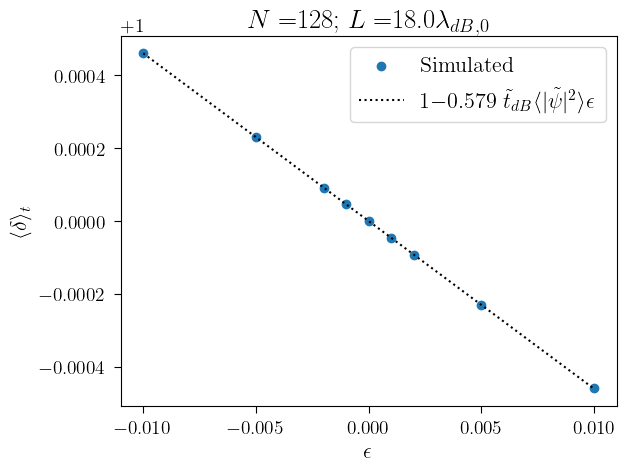

In [53]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, corrections, label="Simulated")
# plt.plot(epsilons, 1-slope*norm*(L/k_max/2)/4*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\langle \tilde{\rho}\rangle \frac{\tilde{T}}{4}\epsilon$",linestyle=":",color="k")
# plt.plot(epsilons, 1-slope*norm*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\langle \tilde{\rho}\rangle\epsilon$",linestyle=":",color="k")
# plt.plot(epsilons, 1-slope*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\epsilon$",linestyle=":",color="k")
plt.plot(epsilons[1:], 1-slope*norm*t_dB*epsilons[1:], label=r"$1-$"+str(round(slope,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
plt.ylabel(r"${\langle \delta\rangle_t}$",rotation=90, labelpad=5)
plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("density-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

Notice that
$$ \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle \epsilon = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 r_0^2  = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 \frac{t_0}{2m} =  g \frac{t_{dB}\langle |\psi|^2 \rangle}{2} = g\frac{\lambda_{dB}^2 \bar{\rho}}{2}$$

### Expectation value of $k$:

$P(k)$ has the right dimensions to be a probability density function over $k$-space. Let's take that literally for a moment and compute the expected value of $k$:

$$E[k] = \int d^dk P(k) k.$$

We can try using this $k$ to compute corrections at different couplings:

$$ \frac{\delta k}{k_0} \equiv \frac{\int d^dk \langle P(k, \epsilon \neq 0)\rangle_t k }{\int d^dk \langle P(k, \epsilon = 0)\rangle_t k} - 1$$

In [62]:
# Nk =[i for i in range(len(k_modes)) if k_modes[i] < k_dB][-1] # index of k_dB

kexp = np.zeros((epsilons.size))

n = 0
for e in epsilons:
#     kexp[n] = np.sqrt(np.sum(k_modes**2*spectra[n,:]))
    kexp[n] = (np.sum(k_modes*spectra[n,:]))
    n += 1

dk = kexp/kexp[0] - 1

def fitk(eps, b):
    return  - b*norm*eps*t_dB


poptk, pcovk = curve_fit(fitk,  epsilons, dk)

slopek = poptk[0]

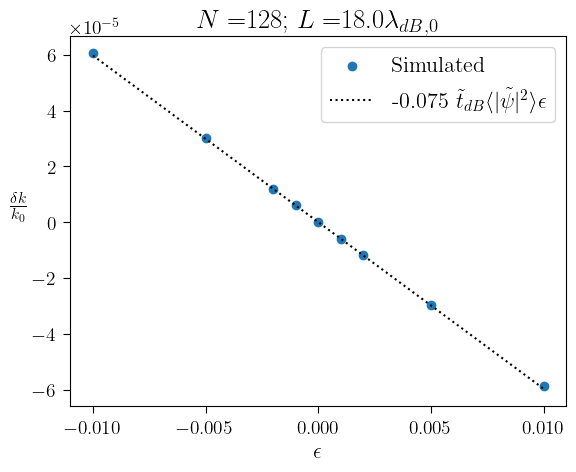

In [63]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, dk, label="Simulated")
plt.plot(epsilons[1:], -slopek*norm*t_dB*epsilons[1:], label=str(-round(slopek,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
plt.ylabel(r"$\frac{\delta k}{k_{0}}$",rotation=0, labelpad=10)
plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("k-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [64]:
slope/slopek

7.70936102950917

<!-- so evidently 
$$\boxed{ \delta = 1 + \frac{1}{d}\frac{\delta k}{k_0}}$$
whereas I would have predicted 
$$\delta = 1 + d\frac{\delta k}{k_0} $$
in $d$ spatial dimensions. -->

### Speed distribution

Let's try looking at the phase of the wavefunction.

In [57]:
# thetas = np.angle(psis[:,:,:,:])

# velocities = -np.asarray(np.gradient(thetas,  L/N, axis=(2,3))) # dx = L/N, axis (2,3) are spatial parts of array

In [58]:
# speeds = np.linalg.norm(velocities, ord=1, axis =0)
# a, b, c, d  = np.shape(speeds)
# speeds = speeds.reshape((a, b, c*d))
# np.shape(speeds)

In [59]:
# plt.figure()
# plt.hist(speeds[0,-1,:]/np.average(speeds[0,-1,:]), bins="auto", label=r"$\epsilon=0$", density=True)
# # plt.hist(speeds[-1,-1,:,], bins="auto", label=r"$\epsilon=$"+str(epsilons[-1]))
# # plt.hist(speeds[1,-1,:,], bins="auto")
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.axvline(x = np.mean(speeds[0,-1,:,]) , label=r"$\epsilon=0$", color="k")
# # plt.axvline(x = np.mean(speeds[-1,-1,:,]) , label=r"$\epsilon=$"+str(epsilons[-1]), color="g")
# # plt.axvline(x = np.mean(speeds[1,-1,:,]) , label=r"$\epsilon=$"+str(epsilons[1]))
# plt.legend()
# plt.show()

In [60]:
# mean_speeds = np.average(speeds, axis=(1,2))

# stds = np.average(speeds, axis = 1)
# stds = np.std(stds, axis = 1)

# dv = mean_speeds/mean_speeds[0]-1
# dsigma = stds/stds[0]-1

# def func(eps, a):
#     return a*t_dB*norm*eps

# popt1, pcov1 = curve_fit(func,  epsilons, dv)
# popt2, pcov2 = curve_fit(func,  epsilons, dsigma)

# slope_v = popt1[0]
# slope_sigma = popt2[0]

In [61]:
# plt.figure()
# plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
# plt.scatter(epsilons, dv, label="Simulation")
# plt.plot(epsilons[1:], slope_v*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_v,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
# plt.ylabel(r"$\frac{\delta v}{v_{0}}$", rotation=0)
# plt.xlabel(r"$\epsilon$")
# plt.legend()
# # plt.savefig("velocity-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
# plt.show()

# plt.figure()
# plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
# plt.scatter(epsilons, stds/stds[0]-1, label="Simulation")
# plt.plot(epsilons[1:], slope_sigma*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_sigma,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
# plt.ylabel(r"$\frac{\delta \sigma_v}{\sigma_{v_0}}$", rotation=0)
# plt.xlabel(r"$\epsilon$")
# plt.legend()
# # plt.savefig("velocity-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
# plt.show()

## Comments
extremely experimental: use the slope to define the new $\lambda_{dB}$

Theory reason that $k_{rms}\rightarrow \delta-1 = \frac{3}{d} \frac{\delta k}{k}$ but $\langle k \rangle\rightarrow \delta-1 = \frac{1}{d} \frac{\delta k}{k}$???

Go to 3d

$$
\delta \approx 1 + d \frac{\delta k}{k_0}
$$